## PART 1: Environment & Configuration
Description: This module establishes the runtime environment. It handles library imports and specifically configures the interface between the Python kernel and the external Tesseract-OCR binary engine. It performs a file-system check to ensure the OCR engine is accessible via the system PATH or local AppData, preventing runtime failures in downstream modules.

In [8]:
# ===============================
# CELL 1 — ENVIRONMENT & CONFIG
# ===============================

import os
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# -------------------------------
# DEVICE CONFIG
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# DATASET CONFIG (LINE-LEVEL OCR)
# -------------------------------
DATASET_ROOT = "ocr_line_dataset"

IMAGE_DIR = os.path.join(DATASET_ROOT, "images")
LABEL_FILE = os.path.join(DATASET_ROOT, "labels.txt")

os.makedirs(IMAGE_DIR, exist_ok=True)

# -------------------------------
# IMAGE NORMALIZATION PARAMS
# -------------------------------
IMG_HEIGHT = 32          # fixed height
IMG_MAX_WIDTH = 512      # max width after resize


Using device: cuda


In [14]:
# ============================================================
# GLOBAL CONFIG — INPUT IMAGE
# ============================================================

IMAGE_PATH = r"F:\AneekProject\Python\Practice Python 14\Image\IMG-20251203-WA0001.jpg"

assert os.path.exists(IMAGE_PATH), f"IMAGE_PATH not found: {IMAGE_PATH}"


## PART 2: Preprocessing & Segmentation Module ("The Slicer")
Description: This function implements the primary Computer Vision pipeline. It bypasses simple global thresholding in favor of Adaptive Gaussian Thresholding, allowing the system to separate foreground text from background noise regardless of lighting gradients (shadows).

Grayscale Conversion: Reduces channel complexity.

Adaptive Thresholding: Calculates local thresholds (11x11 block size) to binarize the image.

Morphological Opening: Uses a 2x2 kernel to erode and dilate, removing high-frequency noise (dust/grain).

Contour Extraction: Utilizes RETR_EXTERNAL to retrieve external boundaries of connected components.

Geometric Filtering: Applies heuristics on Aspect Ratio (0.2 < AR < 4.0) and Bounding Box dimensions to discard non-text artifacts.

In [10]:
# ============================================================
# CELL 2 — LINE-LEVEL PREPROCESSING (CTC OCR READY)
# ============================================================
# PURPOSE:
#   - Extract full text lines (NOT characters)
#   - No slicing, no labeling, no heuristics
#   - Output is suitable for CNN → RNN → CTC OCR
#
# DEPRECATED:
#   - Character slicing
#   - Per-letter crops
#   - Manual split/merge logic
# ============================================================

import os
import cv2
import numpy as np
from PIL import Image

# ------------------------------------------------------------
# Image Loader (robust)
# ------------------------------------------------------------
def load_image(image_path_or_array):
    if isinstance(image_path_or_array, (str, os.PathLike)):
        img = cv2.imread(str(image_path_or_array))
        if img is None:
            pil = Image.open(image_path_or_array).convert("RGB")
            img = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    elif isinstance(image_path_or_array, np.ndarray):
        img = image_path_or_array.copy()
    else:
        raise TypeError("Input must be image path or numpy array")
    return img


# ------------------------------------------------------------
# Line Extraction (CORE FUNCTION)
# ------------------------------------------------------------
def extract_text_lines(image_path_or_array,
                       min_line_height=20,
                       bin_block_size=15,
                       bin_C=5):
    """
    Extract full handwritten / printed text lines.

    RETURNS:
      List of dicts:
        {
          'line_img': binary uint8 image (0/255),
          'coords': (x, y, w, h)
        }

    NOTES:
      - No character slicing
      - No word splitting
      - Designed for CTC OCR
    """

    img = load_image(image_path_or_array)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- Adaptive binarization ---
    binary = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        bin_block_size,
        bin_C
    )

    # --- Horizontal dilation to JOIN characters into lines ---
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 3))
    merged = cv2.dilate(binary, kernel, iterations=1)

    # --- Find contours (each ≈ one line) ---
    contours, _ = cv2.findContours(
        merged,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    lines = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        if h < min_line_height:
            continue

        line_crop = binary[y:y+h, x:x+w]
        line_crop = (line_crop > 127).astype(np.uint8) * 255

        lines.append({
            "line_img": line_crop,
            "coords": (x, y, w, h)
        })

    # Sort top → bottom
    lines.sort(key=lambda l: l["coords"][1])

    return lines


# ------------------------------------------------------------
# Optional Visualization (SAFE, NO SIDE EFFECTS)
# ------------------------------------------------------------
def visualize_lines(image_path_or_array):
    img = load_image(image_path_or_array)
    lines = extract_text_lines(img)

    vis = img.copy()
    for ln in lines:
        x, y, w, h = ln["coords"]
        cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return vis, lines


## PART 3: Data Acquisition & Annotation ("The Contextual Teacher")
Description: This module runs the human-in-the-loop annotation workflow. It invokes the smart_slicer to extract candidates and presents a dual-view UI using matplotlib:

Left View: The isolated, preprocessed binary crop (what the Neural Network will see).

Right View: The contextual RGB region from the original source image with a bounding box overlay (what the Human needs to identify the character). It handles directory management, creating labeled folders dynamically based on user input, and timestamps files to prevent overwriting.

[Cell 3] Detected 5 text lines


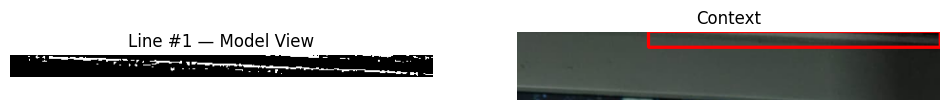

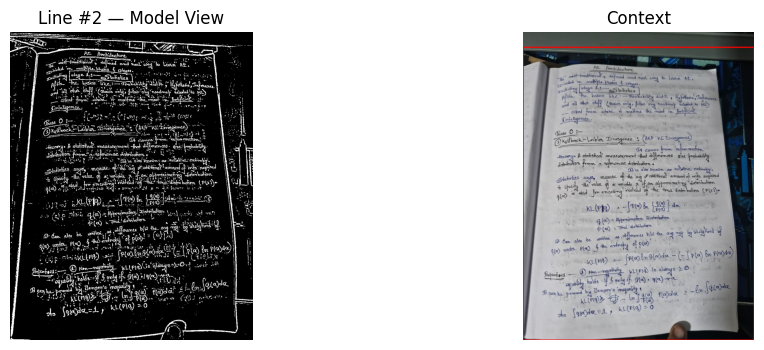

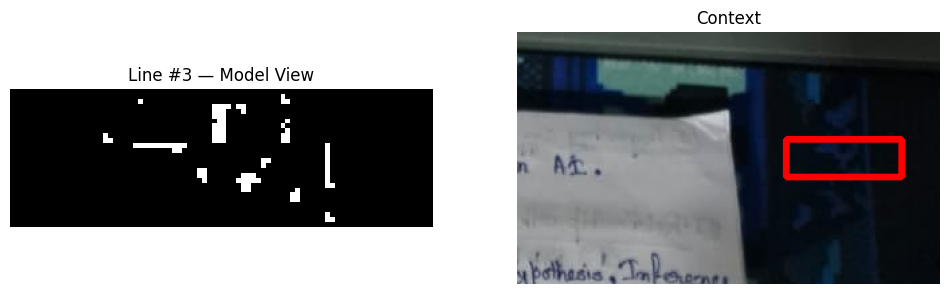

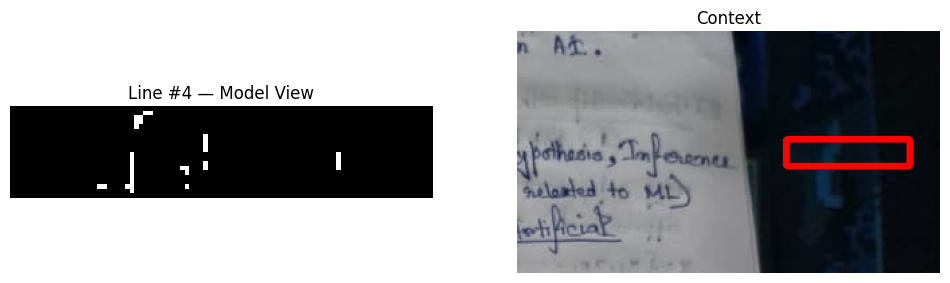

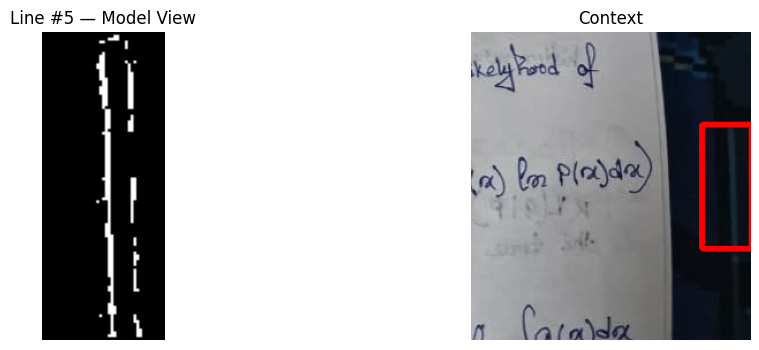

Session done. Saved=0, Skipped=5


In [15]:
# ============================================================
# CELL 3 — LINE-LEVEL DATASET BUILDER (CTC READY)
# ============================================================

import os
import cv2
import time
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

OUTPUT_ROOT = DATASET_ROOT
IMAGES_DIR = os.path.join(OUTPUT_ROOT, "images")
LABEL_FILE = os.path.join(OUTPUT_ROOT, "labels.txt")

os.makedirs(IMAGES_DIR, exist_ok=True)

def load_original_image(path):
    img = cv2.imread(path)
    if img is None:
        pil = Image.open(path).convert("RGB")
        img = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    return img

# ---- LOAD IMAGE USING IMAGE_PATH ----
original_bgr = load_original_image(IMAGE_PATH)
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

# ---- EXTRACT LINES ----
lines = extract_text_lines(IMAGE_PATH)
print(f"[Cell 3] Detected {len(lines)} text lines")

label_fh = open(LABEL_FILE, "a", encoding="utf-8")

saved = 0
skipped = 0

for i, ln in enumerate(lines):
    line_img = ln["line_img"]
    x, y, w, h = ln["coords"]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(line_img, cmap="gray")
    plt.title(f"Line #{i+1} — Model View")
    plt.axis("off")

    context = original_rgb.copy()
    cv2.rectangle(context, (x, y), (x+w, y+h), (255, 0, 0), 3)

    pad_y, pad_x = 80, 200
    y1 = max(0, y - pad_y)
    y2 = min(context.shape[0], y + h + pad_y)
    x1 = max(0, x - pad_x)
    x2 = min(context.shape[1], x + w + pad_x)

    plt.subplot(1, 2, 2)
    plt.imshow(context[y1:y2, x1:x2])
    plt.title("Context")
    plt.axis("off")

    plt.show()

    text = input("Enter full line text ('/s' skip, '/q' quit): ").strip()

    if text == "/q":
        break
    if text == "" or text == "/s":
        skipped += 1
        continue

    ts = int(time.time() * 10000)
    fname = f"line_{ts}.png"
    out_path = os.path.join(IMAGES_DIR, fname)

    # Normalize height to 32
    h0, w0 = line_img.shape
    scale = 32 / h0
    new_w = int(w0 * scale)
    resized = cv2.resize(line_img, (new_w, 32), interpolation=cv2.INTER_AREA)

    cv2.imwrite(out_path, resized)
    label_fh.write(f"{fname}|{text}\n")
    label_fh.flush()

    saved += 1
    print(f"Saved: {fname}")

label_fh.close()
print(f"Session done. Saved={saved}, Skipped={skipped}")


## PART 4: Neural Network Architecture ("The Brain")
### Description:
This class defines the Convolutional Neural Network (CNN) topology using torch.nn.Feature Extraction: Three Convolutional blocks (conv1 to conv3) with Max Pooling. This hierarchical structure extracts low-level features (edges) first, then high-level features (loops, intersections).Dimensionality Reduction: Compresses the input $32 \times 32$ image into a flat feature vector.Classification: Two Fully Connected (Dense) layers map features to the specific character classes. Includes Dropout(0.2) to regularize the model and prevent overfitting on the small dataset.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyHandwritingNet(nn.Module):
    def __init__(self, num_classes):
        super(MyHandwritingNet, self).__init__()

        # INPUT SIZE: 1 × 48 × 48  (your normalized crop size)

        # ---- Convolution Stack ----
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # → 16 × 48 × 48
        self.pool = nn.MaxPool2d(2, 2)                            # → 16 × 24 × 24

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # → 32 × 24 × 24
        # pool  → 32 × 12 × 12

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # → 64 × 12 × 12
        # pool → 64 × 6 × 6

        # ---- Classifier ----
        # FINAL FEATURE MAP SIZE = 64 * 6 * 6 = 2304
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Expect x.shape: (batch, 1, 48, 48)
        if x.ndim != 4:
            raise ValueError(f"Expected 4D tensor (B,1,48,48), got: {x.shape}")

        x = self.pool(F.relu(self.conv1(x)))   # → 16×24×24
        x = self.pool(F.relu(self.conv2(x)))   # → 32×12×12
        x = self.pool(F.relu(self.conv3(x)))   # → 64×6×6

        # Flatten
        x = x.view(x.size(0), -1)  # → (batch, 2304)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## PART 5: Logic Utilities (Reconstruction & RL)
Description: Helper functions for future inference and active learning steps:

on_user_correction: Implements the Reinforcement Learning / Active Learning feedback loop logic. It saves misclassified samples to the correct ground-truth folder to improve future training.

reconstruct_sentence: A heuristic algorithm that takes a list of spatially scattered character predictions and reconstructs the linear sentence structure. It calculates average character width to dynamically determine space thresholds.

In [5]:
# --- CELL 5: ONLINE CORRECTION & LINE RECONSTRUCTION HELPERS ---

import os
import time
import numpy as np
import cv2

def on_user_correction(image_crop, predicted_char, actual_char, save_root=DATASET_ROOT):
    """
    Handle a user correction event.

    Args:
      image_crop: numpy array (the crop as seen by the model). May be grayscale or RGB.
      predicted_char: str (model prediction)
      actual_char: str (user-corrected label)
      save_root: root folder where dataset folders live (defaults to DATASET_ROOT)

    Returns:
      (message, trigger_finetuning) where trigger_finetuning is a bool indicating whether
      a retraining/finetune should be scheduled.
    """
    trigger_finetuning = False

    # Normalize label-to-folder mapping for a few special tokens, otherwise keep as-is
    mapping = {"?": "ques", ".": "dot", "/": "slash"}
    safe_label = mapping.get(actual_char, actual_char)

    if predicted_char == actual_char:
        # Optionally, you could save a fraction of correctly predicted samples to reinforce.
        # For now, do nothing but return a confirmation message.
        return (f"Confirmed: prediction '{predicted_char}' was correct.", False)
    else:
        # Save the corrected crop to the appropriate class folder so it becomes training data.
        save_dir = os.path.join(save_root, safe_label)
        os.makedirs(save_dir, exist_ok=True)

        # Create a timestamped filename
        timestamp = int(time.time() * 10000)
        filename = f"{timestamp}.png"
        filepath = os.path.join(save_dir, filename)

        # We prefer to save the normalized 48x48 crop if available (normalize_crop_for_storage).
        try:
            norm = normalize_crop_for_storage(image_crop, target=48, pad=6)
            cv2.imwrite(filepath, norm)
        except Exception:
            # Fall back to saving the raw crop (converted to uint8)
            try:
                raw = image_crop.copy()
                if raw.dtype != np.uint8:
                    raw = (255 * (raw - raw.min()) / (raw.ptp() + 1e-8)).astype(np.uint8)
                # If multi-channel, convert to gray
                if raw.ndim == 3:
                    raw = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(filepath, raw)
            except Exception as e:
                return (f"Failed to save corrected sample: {e}", False)

        # Flag that we should consider finetuning / collecting this for a retrain run
        trigger_finetuning = True
        return (f"I have learned that this shape is a '{actual_char}' and saved it to {filepath}.", True)


def group_into_lines(predictions, line_height_tol=None):
    """
    Group predicted character boxes into lines of text.

    Args:
      predictions: list of dicts with at least keys: 'x','y','w','h','char'
        - x,y are top-left coordinates
      line_height_tol: optional pixel tolerance. If None, derived from median box height.

    Returns:
      list of lines, where each line is a list of predictions sorted by x (left-to-right).
    """
    if not predictions:
        return []

    preds = []
    for p in predictions:
        # compute vertical center to make grouping more robust to varying box heights
        cx = float(p['x']) + float(p['w']) / 2.0
        cy = float(p['y']) + float(p['h']) / 2.0
        preds.append({**p, 'cy': cy, 'cx': cx})

    # sort by vertical center (top to bottom)
    preds = sorted(preds, key=lambda p: p['cy'])

    # derive tolerance from median height if not provided
    heights = [p['h'] for p in preds if p.get('h', 0) > 0]
    median_h = float(np.median(heights)) if heights else 20.0
    if line_height_tol is None:
        line_height_tol = max(8.0, median_h * 0.8)

    lines = []
    current = [preds[0]]
    for p in preds[1:]:
        if abs(p['cy'] - current[-1]['cy']) <= line_height_tol:
            current.append(p)
        else:
            # finalize the line (sorted left-to-right)
            lines.append(sorted(current, key=lambda q: q['x']))
            current = [p]
    if current:
        lines.append(sorted(current, key=lambda q: q['x']))

    return lines


def line_to_text(line_preds):
    """
    Convert a single horizontally-ordered line (list of preds with x,w,char) into a text string.
    Heuristic: determine a dynamic space threshold based on median inter-character gap.
    """
    if not line_preds:
        return ""

    # ensure sorted left-to-right
    line = sorted(line_preds, key=lambda p: p['x'])

    # compute gaps between adjacent boxes
    gaps = []
    for i in range(len(line) - 1):
        right_end = line[i]['x'] + line[i]['w']
        next_left = line[i + 1]['x']
        gap = next_left - right_end
        gaps.append(max(0, gap))

    # robust gap threshold: use median of positive gaps or fallback to scaled median width
    pos_gaps = [g for g in gaps if g > 0]
    if pos_gaps:
        median_gap = float(np.median(pos_gaps))
    else:
        # fallback: use typical character width as baseline
        median_gap = float(np.median([p['w'] for p in line])) * 0.3

    # threshold above which we assume a space between words
    space_thresh = max(8.0, median_gap * 1.6)

    out_chars = []
    for i, p in enumerate(line):
        if i > 0:
            prev = line[i - 1]
            prev_end = prev['x'] + prev['w']
            gap = p['x'] - prev_end
            if gap > space_thresh:
                out_chars.append(" ")
        # append character (safe fallback if 'char' missing)
        out_chars.append(str(p.get('char', '?')))

    return "".join(out_chars)


def reconstruct_full_text(predictions):
    """
    Reconstruct full text from list of predictions by grouping into lines and joining.
    Returns a multi-line string.
    """
    lines = group_into_lines(predictions)
    texts = [line_to_text(l) for l in lines]
    return "\n".join(texts)


This cell defines the full training loop for the Personal OCR model.
It loads the labeled dataset, applies augmentations, constructs dataloaders, trains the CNN over multiple epochs, evaluates accuracy on a validation split, and finally saves both the model weights and the class-index mapping.
This training pipeline is fully synchronized with the 48×48 crop normalization done in previous cells.

--- INITIALIZING TRAINING PIPELINE ---
Detected 30 classes: ['(', ')', '0', '1', 'A', 'I', 'J', 'M', 'O', 'S', 'W', '_junk', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'n', 'p', 'q', 'r', 't', 'u', 'x', 'y', 'z']
Computation Device: cpu

--- STARTING 60 EPOCHS ---
Epoch 10/60 | Loss: 1.8224
Epoch 20/60 | Loss: 1.0766
Epoch 30/60 | Loss: 0.4966
Epoch 40/60 | Loss: 0.2708
Epoch 50/60 | Loss: 0.3630
Epoch 60/60 | Loss: 0.2193

--- TRAINING COMPLETE ---
Final Validation Accuracy: 55.75%
Saved model → 'my_handwriting_brain.pth'
Saved class mapping → 'class_map.json'


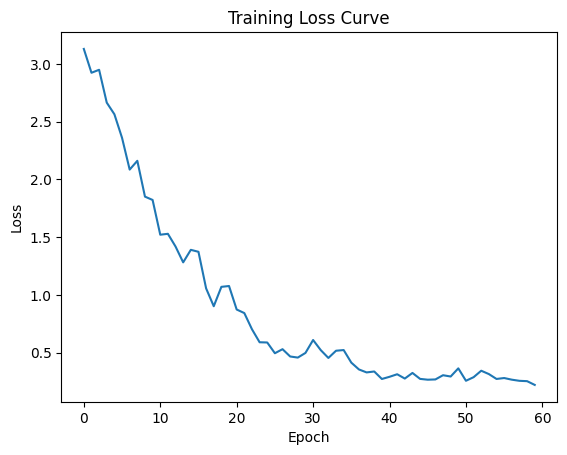

In [7]:
# --- CELL 6: TRAINING PIPELINE FOR THE HANDWRITING BRAIN ---
#
# This cell loads your labeled crop dataset, applies training augmentations,
# creates train/validation splits, trains the CNN from Cell 4 on 48×48 images,
# evaluates accuracy, logs the loss curve, and saves both the model weights
# and the class mapping. This is the full OCR training brain.

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import json

def train_my_brain():
    print("--- INITIALIZING TRAINING PIPELINE ---")

    # 1. DATA AUGMENTATION (IMPORTANT: keep size = 48x48 to match crop normalization)
    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.RandomRotation(10),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.08, 0.08),
            scale=(0.9, 1.15)
        ),
        transforms.ToTensor(),
    ])

    # Test data stays clean
    test_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
    ])

    # 2. LOAD DATASET
    try:
        full_dataset = datasets.ImageFolder(root=DATASET_ROOT)
    except Exception as e:
        print(f"CRITICAL ERROR: Could not load data from {DATASET_ROOT}: {e}")
        return

    classes = full_dataset.classes
    print(f"Detected {len(classes)} classes: {classes}")

    if len(classes) < 2:
        print("ERROR: Need at least 2 labeled characters before training.")
        return

    # Split dataset 80/20
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

    # Assign transforms to the underlying dataset
    full_dataset.transform = None  # prevent conflict
    train_subset.dataset.transform = train_transform
    test_subset.dataset.transform = test_transform

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    # 3. MODEL SETUP
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Computation Device: {device}")

    model = MyHandwritingNet(num_classes=len(classes)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # 4. TRAINING LOOP
    EPOCHS = 60
    print(f"\n--- STARTING {EPOCHS} EPOCHS ---")
    loss_history = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

    # 5. VALIDATION
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total if total > 0 else 0

    print("\n--- TRAINING COMPLETE ---")
    print(f"Final Validation Accuracy: {accuracy:.2f}%")

    # 6. SAVE ARTIFACTS
    torch.save(model.state_dict(), "my_handwriting_brain.pth")

    with open("class_map.json", "w") as f:
        json.dump(full_dataset.class_to_idx, f, indent=2)

    print("Saved model → 'my_handwriting_brain.pth'")
    print("Saved class mapping → 'class_map.json'")

    # Plot learning curve
    plt.plot(loss_history)
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


# RUN THE TRAINING
train_my_brain()


Vocabulary size: 71


In [9]:
# %% [markdown]
# ## CELL 1: Line-Level OCR Dataset (NO Character Slicing)

# %%
from torch.utils.data import Dataset
from torchvision import transforms

class LineOCRDataset(Dataset):
    def __init__(self, samples):
        """
        samples = [
            {"image_path": "...", "text": "..."},
            ...
        ]
        """
        self.samples = samples
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def encode(self, text):
        return torch.tensor(
            [char2idx[c] for c in text if c in char2idx],
            dtype=torch.long
        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        img = cv2.imread(item["image_path"], cv2.IMREAD_GRAYSCALE)

        if img is None:
            raise RuntimeError(f"Failed to load {item['image_path']}")

        img = self.transform(img)
        label = self.encode(item["text"])

        return img, label


In [10]:
# %% [markdown]
# ## CELL 3: CNN + BiLSTM OCR Model (CTC)

# %%
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU()
        )

        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # x: (B,1,H,W)
        feat = self.cnn(x)          # (B,C,H,W)
        feat = feat.mean(dim=2)     # (B,C,W)
        feat = feat.permute(0,2,1)  # (B,W,C)

        seq, _ = self.lstm(feat)
        out = self.fc(seq)

        return out


In [11]:
# %% [markdown]
# ## CELL 4: CTC Loss & Decoder

# %%
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

def ctc_decode(logits):
    preds = logits.argmax(dim=-1)
    results = []

    for p in preds:
        last = None
        text = []
        for i in p:
            i = i.item()
            if i != last and i != 0:
                text.append(idx2char[i])
            last = i
        results.append("".join(text))

    return results


In [12]:
# %% [markdown]
# ## CELL 6: OCR Training Loop (CTC-Based)

# %%
def train_ocr(dataset):
    loader = DataLoader(dataset, batch_size=4, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CRNN(NUM_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(30):
        model.train()
        total_loss = 0

        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs.unsqueeze(1))
            log_probs = logits.log_softmax(2)

            input_lengths = torch.full(
                (imgs.size(0),),
                log_probs.size(1),
                dtype=torch.long
            )

            target_lengths = torch.tensor(
                [len(l) for l in labels],
                dtype=torch.long
            )

            loss = ctc_loss(
                log_probs.permute(1,0,2),
                torch.cat(labels),
                input_lengths,
                target_lengths
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

    torch.save(model.state_dict(), "ocr_ctc.pth")
